In [ ]:
import numpy as np
import torch
import torch.optim as optim
import matplotlib.pyplot as plt


In [ ]:
no_samples = 7521
high = 9
low = 2
sample_x = []
sample_y = []

for i in range(0,no_samples):
  X = []
  l = np.random.randint(low,high)
  x1 = np.random.uniform(0,1,l)
  t1 = torch.tensor(x1)
  # x.append(t1)
  x2 = np.zeros(l)
  var_1 = np.random.randint(1,l)
  var_2 = np.random.randint(1,l)
  if (var_1 == var_2):
    if (var_1 == l):
      var_2 = var_1-1
    else :
      var_2 = var_1+1
  x2[var_1-1] = 1
  x2[var_2-1] = 1 
  t2 = torch.tensor(x2)
  X = [t1,t2] 
  sample_x.append(X)
  Y = t1[var_1-1]+t1[var_2-1]
  sample_y.append(Y)

xyz =torch.tensor([sample_x[0][0][0],sample_x[0][1][0]])
print(xyz.shape)

torch.Size([2])


In [ ]:
x_train = sample_x[0:5555]
y_train = sample_y[0:5555]


x_test = sample_x[5555:7521]  
y_test = sample_y[5555:7521]               

In [ ]:
class ElmanNetwork:
  def __init__(self, input_size, hidden_size, output_size):
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.output_size = output_size

    # Initialize weights
    self.w_xh = torch.rand((hidden_size, input_size),requires_grad=True)
    self.w_hh = torch.rand((hidden_size, hidden_size),requires_grad=True)
    self.w_hy = torch.rand((output_size, hidden_size),requires_grad=True)
        
    # Initialize biases
    self.b_h = torch.zeros((hidden_size, 1),requires_grad=True)
    self.b_y = torch.zeros((output_size, 1),requires_grad=True)
    self.optimizer = optim.SGD((self.w_xh, self.w_hh, self.w_hy, self.b_h, self.b_y), lr=0.01)
    
  def forward(self, x,v):
    h = torch.zeros(self.hidden_size, 1)
    for i in range(0,x.shape[0]):
      s=torch.tensor([x[i],v[i]]).unsqueeze(1)
      h = torch.tanh(torch.matmul(self.w_xh,s.float()) + torch.matmul(self.w_hh,h) + self.b_h)
          
      y = torch.relu(torch.matmul(self.w_hy,h) + self.b_y)
         
    return y

  def train(self, x, y_true, eta, num_epochs): 
      a1 = np.zeros(num_epochs)
      a2 = np.zeros(num_epochs)

      for epoch in range(num_epochs):
       net_loss = 0
       temp=0
       for i in range(0,len(x)):
        # Forward pass
        y_pred = self.forward(x[i][0],x[i][1])
        self.optimizer.zero_grad()

        # Compute loss
        loss = torch.square(y_pred - y_true[i]).sum()
        net_loss += torch.square(y_pred - y_true[i]).sum()
        temp += torch.square(1 - y_true[i]).sum()
        loss.backward()
        self.optimizer.step()

       print(net_loss)
       a1[epoch] = net_loss.detach().numpy()
       a2[epoch] = temp.detach().numpy()   
             
      return a1,a2
                
                

In [ ]:
class LSTM:
  def __init__(self, input_size, hidden_size, output_size, c_size):
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.output_size = output_size
    self.c_size = c_size

    # Initialize weights
    self.w_i = torch.rand((c_size, hidden_size+input_size),requires_grad=True)
    self.w_f = torch.rand((c_size, hidden_size+input_size),requires_grad=True)
    self.w_c = torch.rand((c_size, hidden_size+input_size),requires_grad=True)
    self.w_o = torch.rand((c_size, hidden_size+input_size),requires_grad=True)
    self.w_y = torch.rand((output_size, hidden_size),requires_grad=True)
        
    # Initialize biases
    self.b_f = torch.zeros((c_size, 1),requires_grad=True)
    self.b_c = torch.zeros((c_size, 1),requires_grad=True)
    self.b_i = torch.zeros((c_size, 1),requires_grad=True)
    self.b_o = torch.zeros((c_size, 1),requires_grad=True)
    self.b_y = torch.zeros((output_size, 1),requires_grad=True)
    self.optimizer = optim.SGD((self.w_i, self.w_f, self.w_c, self.w_o, self.w_y, self.b_f, self.b_c, self.b_i, self.b_o, self.b_y), lr=0.01)
    
  def forward(self, x,v):
   h = torch.zeros(self.hidden_size, 1)
   c = torch.zeros(self.hidden_size, 1)
   for i in range(0,x.shape[0]):
    s=torch.tensor([x[i],v[i]]).unsqueeze(1)
    f = torch.sigmoid(torch.matmul(self.w_f,torch.cat((h,s.float()))) + self.b_f)
    i = torch.sigmoid(torch.matmul(self.w_i,torch.cat((h,s.float()))) + self.b_i)
    C = torch.tanh(torch.matmul(self.w_c,torch.cat((h,s.float()))) + self.b_c)
    c = torch.mul(f,c) + torch.mul(i,C)
    o = torch.sigmoid(torch.matmul(self.w_o,torch.cat((h,s.float()))) + self.b_o)
    h = torch.mul(o,torch.tanh(c))

    y = torch.relu(torch.matmul(self.w_y,h) + self.b_y)
    
   return y

  def train(self, x, y_true, eta, num_epochs):  
    a1 = np.zeros(num_epochs)
    a2 = np.zeros(num_epochs)

    for epoch in range(num_epochs):
      net_loss = 0
      temp=0
      for i in range(0,len(x)):
       # Forward pass
       y_pred = self.forward(x[i][0],x[i][1])
       self.optimizer.zero_grad()

       # Compute loss
       loss = torch.square(y_pred - y_true[i]).sum()
       net_loss += torch.square(y_pred - y_true[i]).sum()
       temp += torch.square(1 - y_true[i]).sum()
       loss.backward()
       self.optimizer.step()

      print(net_loss)
      a1[epoch] = net_loss.detach().numpy()
      a2[epoch] = temp.detach().numpy()
       
    return a1,a2   

In [ ]:
class GRU:
  def __init__(self, input_size, hidden_size, output_size):
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.output_size = output_size
  

    # Initialize weights
    self.w_z = torch.rand((hidden_size, hidden_size+input_size),requires_grad=True)
    self.w_r = torch.rand((hidden_size, hidden_size+input_size),requires_grad=True)
    self.w = torch.rand((hidden_size, hidden_size+input_size),requires_grad=True)
    self.w_y = torch.rand((output_size, hidden_size),requires_grad=True)

    self.b_y = torch.zeros((output_size, 1),requires_grad=True)
    self.optimizer = optim.SGD((self.w_z, self.w_r, self.w, self.w_y, self.b_y), lr=0.01)
    
  def forward(self, x,v):
   h = torch.zeros(self.hidden_size, 1)
   for i in range(0,x.shape[0]):
    s=torch.tensor([x[i],v[i]]).unsqueeze(1)
    z = torch.sigmoid(torch.matmul(self.w_z,torch.cat((h,s.float()))))
    r = torch.sigmoid(torch.matmul(self.w_r,torch.cat((h,s.float()))))
    H = torch.tanh(torch.matmul(self.w,torch.cat((torch.mul(r,h),s.float()))))
    I = torch.ones((self.hidden_size, 1))
    h = torch.mul((I-z),h) + torch.mul(z,H)

    y = torch.relu(torch.matmul(self.w_y,h)+self.b_y)

   return y

  def train(self, x, y_true, eta, num_epochs):   
    a1 = np.zeros(num_epochs)
    a2 = np.zeros(num_epochs)

    for epoch in range(num_epochs):
      net_loss = 0
      temp=0
      for i in range(0,len(x)):
       # Forward pass
       y_pred = self.forward(x[i][0],x[i][1])
       self.optimizer.zero_grad()

       # Compute loss
       loss = torch.square(y_pred - y_true[i]).sum()
       net_loss += torch.square(y_pred - y_true[i]).sum()
       temp += torch.square(1 - y_true[i]).sum()
       loss.backward()
       self.optimizer.step()

      print(net_loss)
      a1[epoch] = net_loss.detach().numpy()
      a2[epoch] = temp.detach().numpy()
      
    return a1,a2       

tensor(763.9067, grad_fn=<AddBackward0>)
tensor(198.3982, grad_fn=<AddBackward0>)
tensor(43.0288, grad_fn=<AddBackward0>)
tensor(26.0311, grad_fn=<AddBackward0>)
tensor(19.8040, grad_fn=<AddBackward0>)
tensor(17.6803, grad_fn=<AddBackward0>)
tensor(16.6972, grad_fn=<AddBackward0>)
tensor(16.0635, grad_fn=<AddBackward0>)
tensor(15.5934, grad_fn=<AddBackward0>)
tensor(15.2276, grad_fn=<AddBackward0>)
tensor(14.9375, grad_fn=<AddBackward0>)
tensor(14.7046, grad_fn=<AddBackward0>)
tensor(14.5150, grad_fn=<AddBackward0>)
tensor(14.3573, grad_fn=<AddBackward0>)
tensor(14.2233, grad_fn=<AddBackward0>)
tensor(14.1063, grad_fn=<AddBackward0>)
tensor(14.0018, grad_fn=<AddBackward0>)
tensor(13.9066, grad_fn=<AddBackward0>)
tensor(13.8183, grad_fn=<AddBackward0>)
tensor(13.7352, grad_fn=<AddBackward0>)
tensor(13.6564, grad_fn=<AddBackward0>)
tensor(13.5808, grad_fn=<AddBackward0>)
tensor(13.5080, grad_fn=<AddBackward0>)
tensor(13.4375, grad_fn=<AddBackward0>)
tensor(13.3689, grad_fn=<AddBackward0>

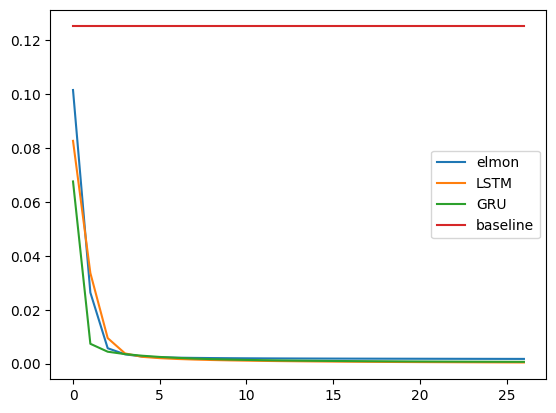

In [ ]:
elman_net = ElmanNetwork(2, 3, 1)
op_e=elman_net.train(x_train, y_train, eta=0.01, num_epochs=27)

lstm = LSTM(2, 3, 1, 3)
op_l=lstm.train(x_train, y_train, eta=0.01, num_epochs=27)

gru = GRU(2, 3, 1)
op_g = gru.train(x_train, y_train, eta=0.01, num_epochs=27)

x_axis = np.zeros(27)
for i in range(0,27):
  x_axis[i] = i
y1 = np.zeros(len(op_e[0]))
for i in range(0,len(op_e[0])):
  y1[i] = op_e[0][i]/no_samples
y2 = np.zeros(len(op_e[1]))
for i in range(0,len(op_e[1])):
  y2[i] = op_e[1][i]/no_samples
y3 = np.zeros(len(op_l[0]))
for i in range(0,len(op_l[0])):
  y3[i] = op_l[0][i]/no_samples
y4 = np.zeros(len(op_g[0]))
for i in range(0,len(op_g[0])):
  y4[i] = op_g[0][i]/no_samples


fig = plt.figure()
ax1 = fig.add_subplot(111)
plt.plot(x_axis, y1, label='elmon')
plt.plot(x_axis, y3, label='LSTM')
plt.plot(x_axis, y4, label='GRU')
plt.plot(x_axis, y2, label='baseline')
plt.legend(loc="center right")
plt.show()


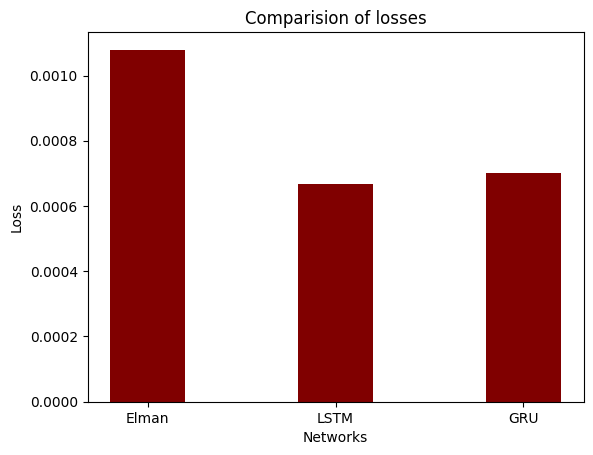

In [ ]:
#Bar-Chart
loss_e = 0
for i in range(len(x_test)):
  y_predict = elman_net.forward(x_test[i][0],x_test[i][1])
  loss_e +=  torch.square(y_predict - y_test[i]).sum()
loss_e = loss_e.detach().numpy()/len(x_test)  

loss_l = 0
for i in range(len(x_test)):
  y_predict = lstm.forward(x_test[i][0],x_test[i][1])
  loss_l +=  torch.square(y_predict - y_test[i]).sum()
loss_l = loss_l.detach().numpy()/len(x_test) 

loss_g = 0
for i in range(len(x_test)):
  y_predict = gru.forward(x_test[i][0],x_test[i][1])
  loss_g +=  torch.square(y_predict - y_test[i]).sum()
loss_g = loss_g.detach().numpy()/len(x_test) 

values = [loss_e, loss_l, loss_g]
names = ['Elman', 'LSTM', 'GRU']
plt.bar(names, values, color ='maroon', width = 0.4)
plt.xlabel("Networks")
plt.ylabel("Loss")
plt.title("Comparision of losses")
plt.show()